In [ ]:
!pip install tensorflow==2.7.0

In [2]:

# import TensorFlow Keras API
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import (
        Activation, BatchNormalization, Concatenate, Dense, Dropout, Multiply,
        Embedding, Flatten, Input, Reshape, LeakyReLU, Conv2D, Conv2DTranspose) 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Define important parameters
img_shape = (28,28,1)
z_dim =100
n_class= 10

In [3]:
# Generator CNN model
def generator_model(z_dim):

    model = Sequential()

    model.add(Dense(256 * 7 * 7, input_dim=z_dim,))
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, 3, 2, padding='same',))
    model.add(LeakyReLU(alpha =0.01))

    model.add(Conv2DTranspose(64, 3, 1, padding='same',))
    model.add(LeakyReLU(alpha =0.01))

    model.add(Conv2DTranspose(1, 3, 2, padding='same',))
    model.add(LeakyReLU(alpha =0.01))

    return model

# generator input 
def generator(z_dim):
    # latent input
    z = Input(shape=(z_dim, ))
    # label input
    label = Input(shape=(1, ), dtype='int32')
    # convert label to embedding
    label_embedding = Embedding(n_class, z_dim)(label)

    label_embedding = Flatten()(label_embedding)
    # dot product two inputs
    joined_representation = Multiply()([z, label_embedding])

    generator = generator_model(z_dim)

    conditioned_img = generator(joined_representation)

    model =  Model([z, label], conditioned_img)
    # save model blueprint to image
    plot_model(model,'generator.jpg',show_shapes=True,show_dtype=True)

    return model

In [4]:
# discriminator CNN model
def discriminator_model(img_shape):

    model = Sequential()

    model.add(Conv2D(64,3,2,input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),))
    model.add(LeakyReLU(alpha =0.01))

    model.add(Conv2D(64,3,2,input_shape=img_shape,padding='same',))
    model.add(LeakyReLU(alpha =0.001))

    model.add(Conv2D(128,3,2,input_shape=img_shape,padding='same',))
    model.add(LeakyReLU(alpha =0.001))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


def discriminator(img_shape):
    # image input
    img = Input(shape=img_shape)
    # label input
    label = Input(shape=(1, ), dtype='int32')

    label_embedding = Embedding(n_class, np.prod(img_shape),input_length=1)(label)

    label_embedding = Flatten()(label_embedding)

    label_embedding = Reshape(img_shape)(label_embedding)
    # concatenate the image and label
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    discriminator = discriminator_model(img_shape)

    classification = discriminator(concatenated)

    model = Model([img, label], classification)

    plot_model(model,'discriminator.jpg',show_shapes=True,show_dtype=True)

    return model

In [5]:
# define a complete GAN architecture
def cgan(generator, discriminator):

    z = Input(shape=(z_dim, ))

    label = Input(shape=(1, ))

    img = generator([z, label])

    classification = discriminator([img, label])

    model = Model([z, label], classification)
    
    return model

discriminator = discriminator(img_shape)
# compile the discriminator architecture 
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = generator(z_dim)
# set discriminator to non-trainanle 
discriminator.trainable = False
# compile the whole C-GAN architectu
cgan = cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

4431872/4422102 [==============================] - 0s 0us/step
2000 [D loss: 0.253146, acc.: 89.45%] [G loss: 3.160290]
Epoch : 2001 
4000 [D loss: 0.285852, acc.: 87.89%] [G loss: 2.541404]
Epoch : 4001 
6000 [D loss: 0.263299, acc.: 90.23%] [G loss: 2.964139]
Epoch : 6001 
8000 [D loss: 0.263355, acc.: 91.02%] [G loss: 3.059823]
Epoch : 8001 
10000 [D loss: 0.222944, acc.: 90.62%] [G loss: 3.082450]
Epoch : 10001 
12000 [D loss: 0.262140, acc.: 91.02%] [G loss: 2.881611]
Epoch : 12001 
14000 [D loss: 0.286580, acc.: 87.11%] [G loss: 4.059137]
Epoch : 14001 
16000 [D loss: 0.229758, acc.: 92.19%] [G loss: 4.299975]
Epoch : 16001 
18000 [D loss: 0.132499, acc.: 95.31%] [G loss: 3.784738]
Epoch : 18001 
20000 [D loss: 0.166051, acc.: 93.75%] [G loss: 4.366072]
Epoch : 20001 


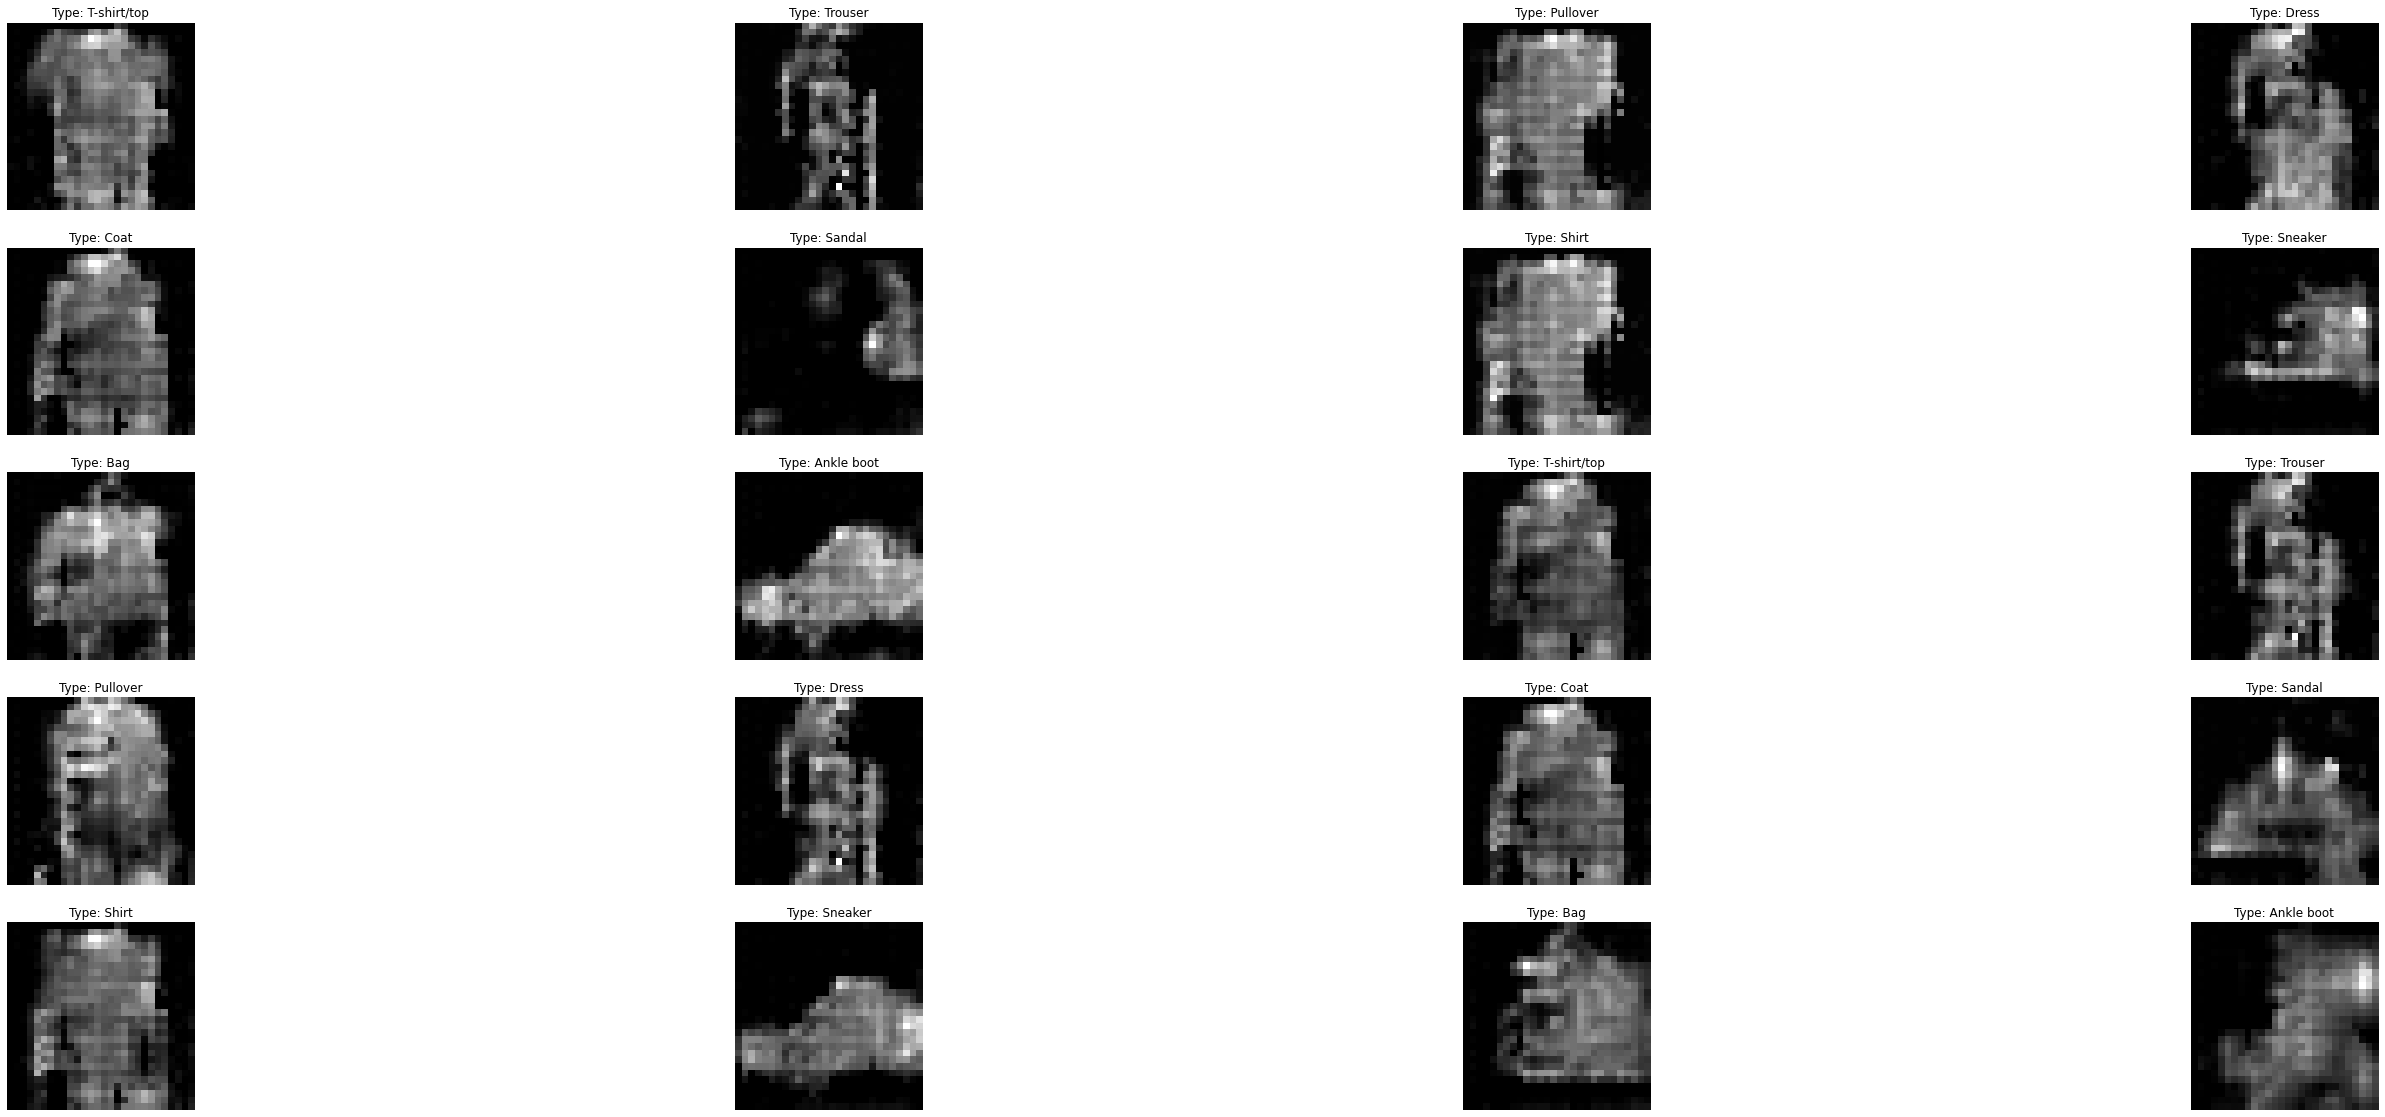

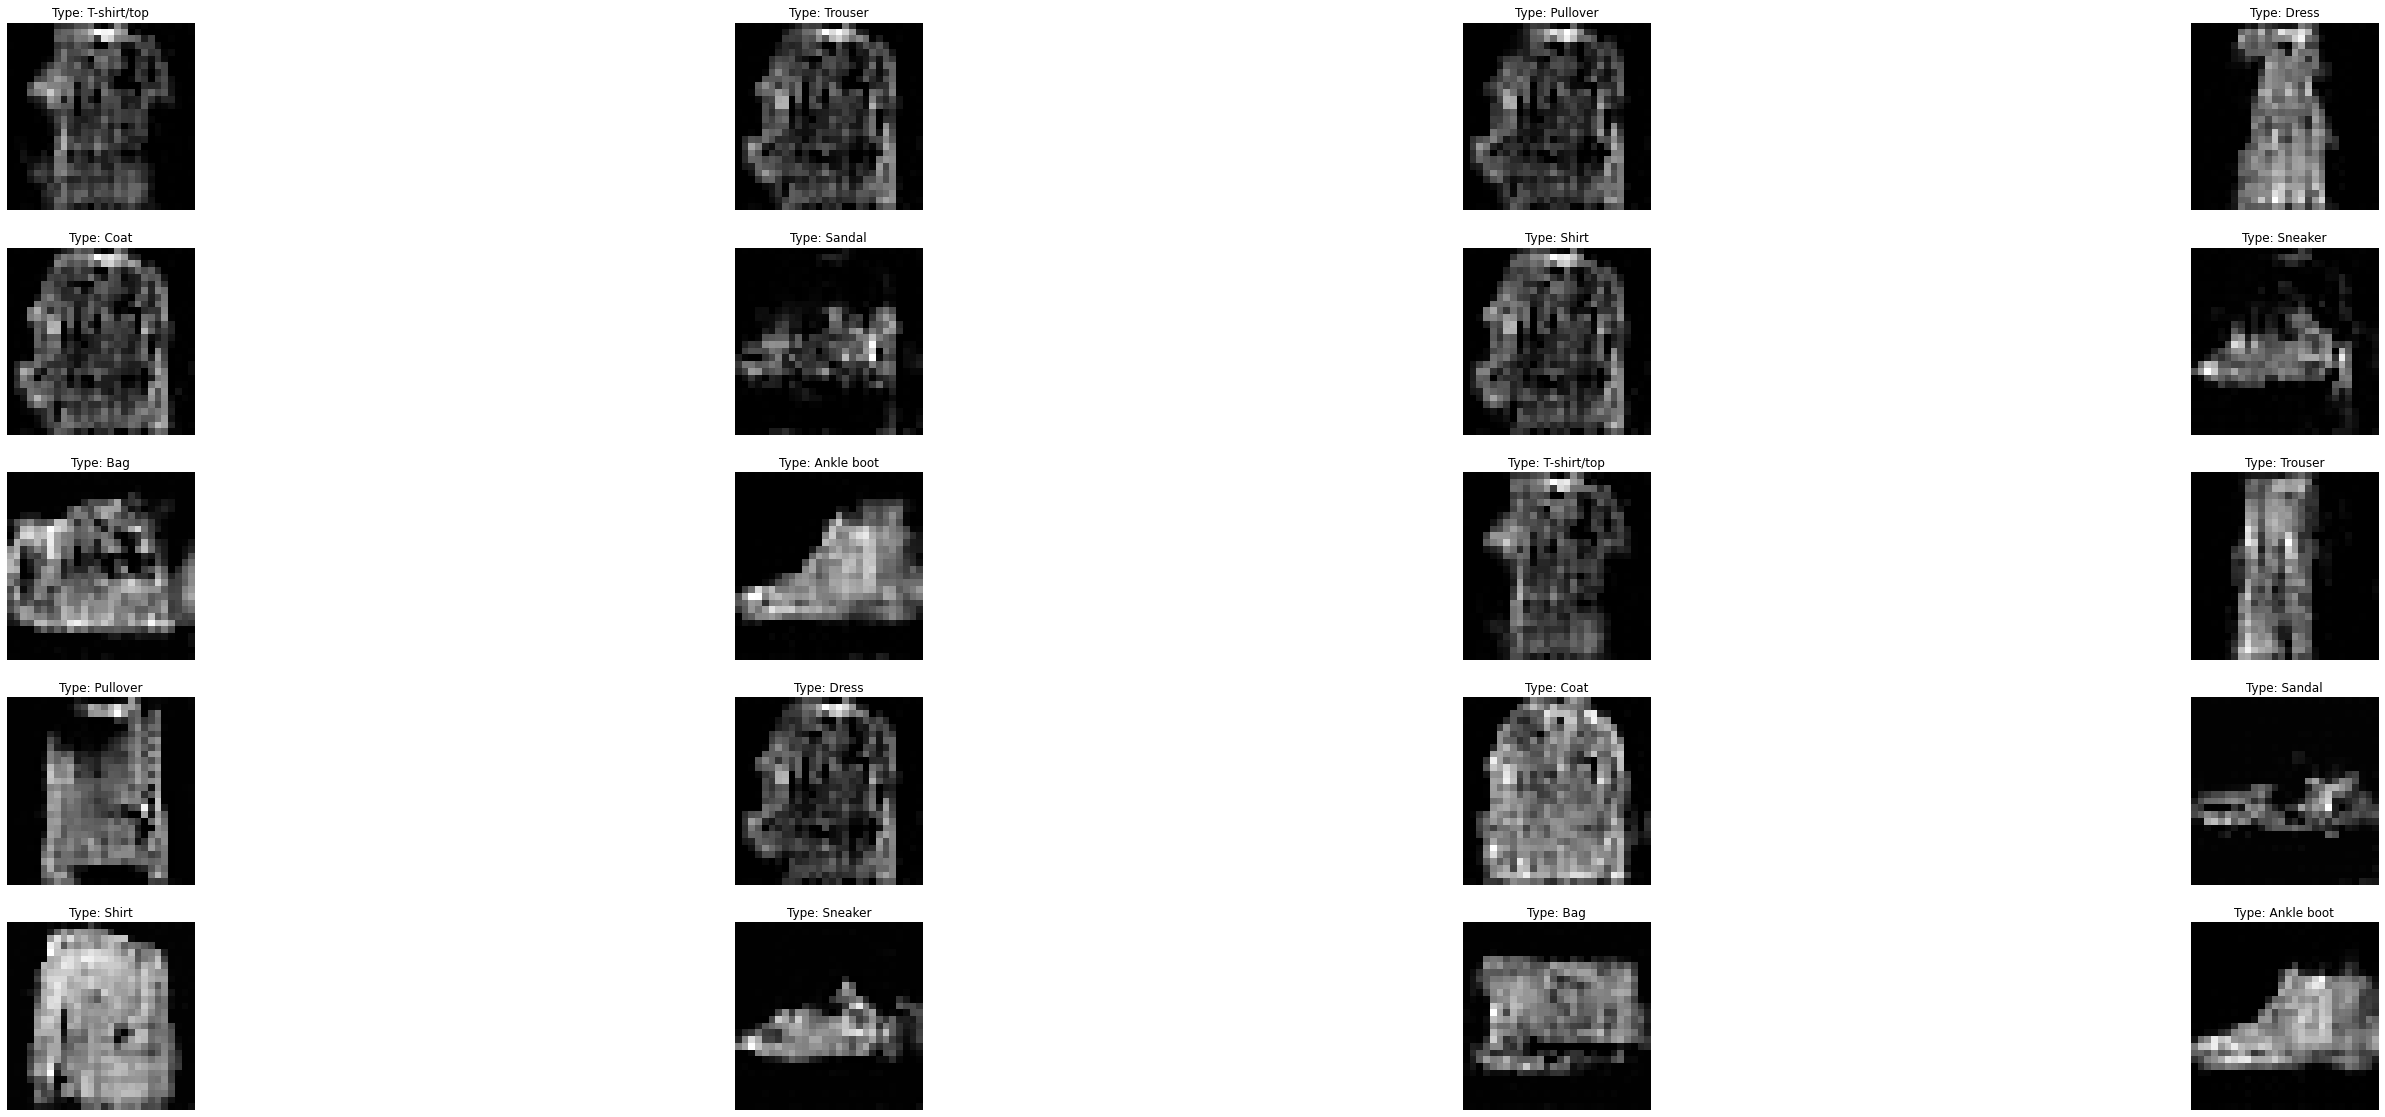

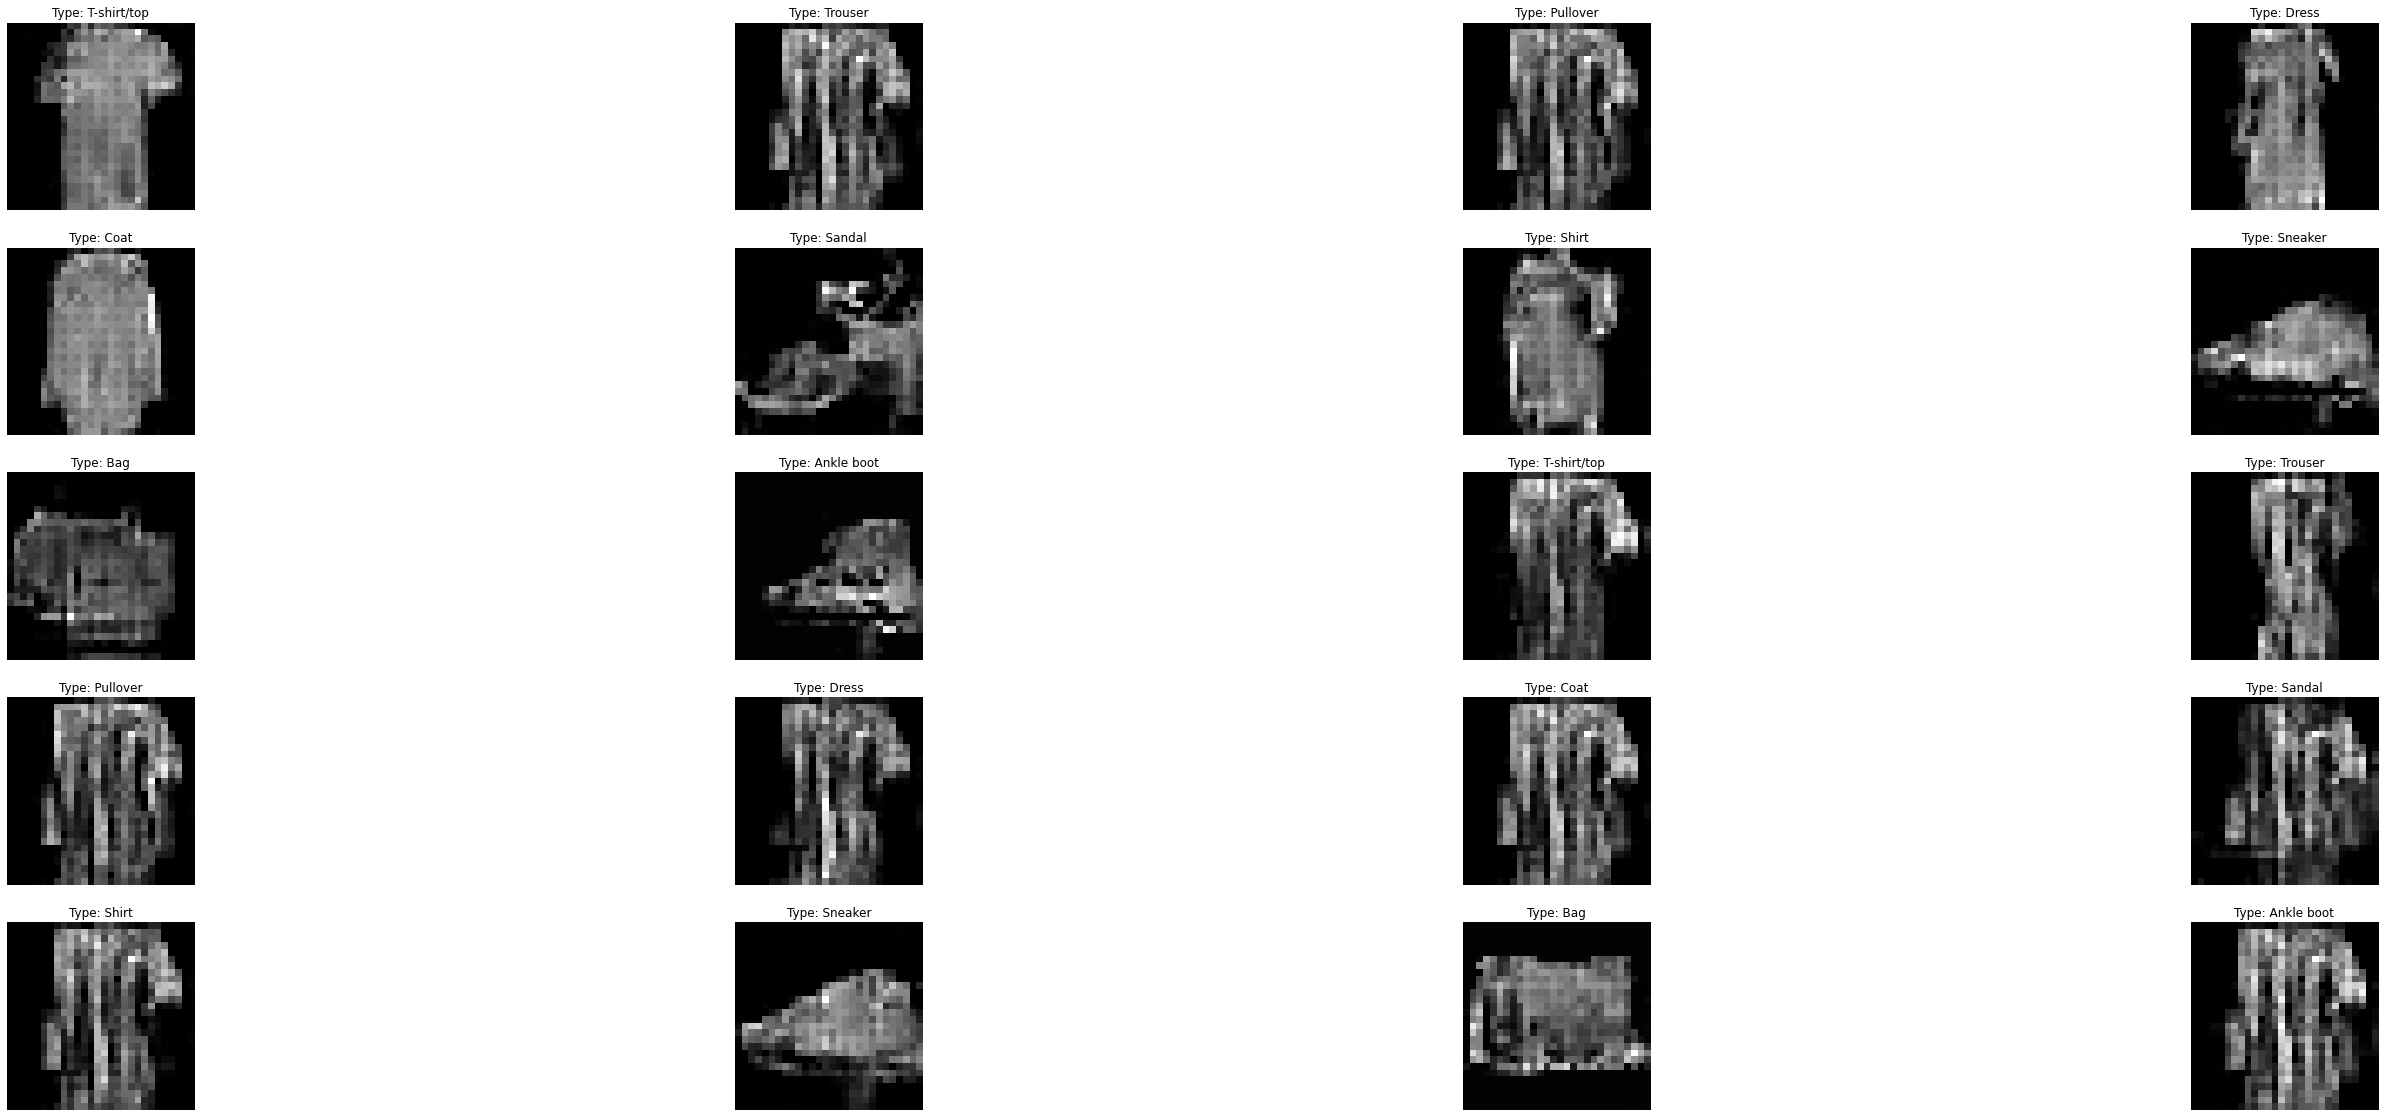

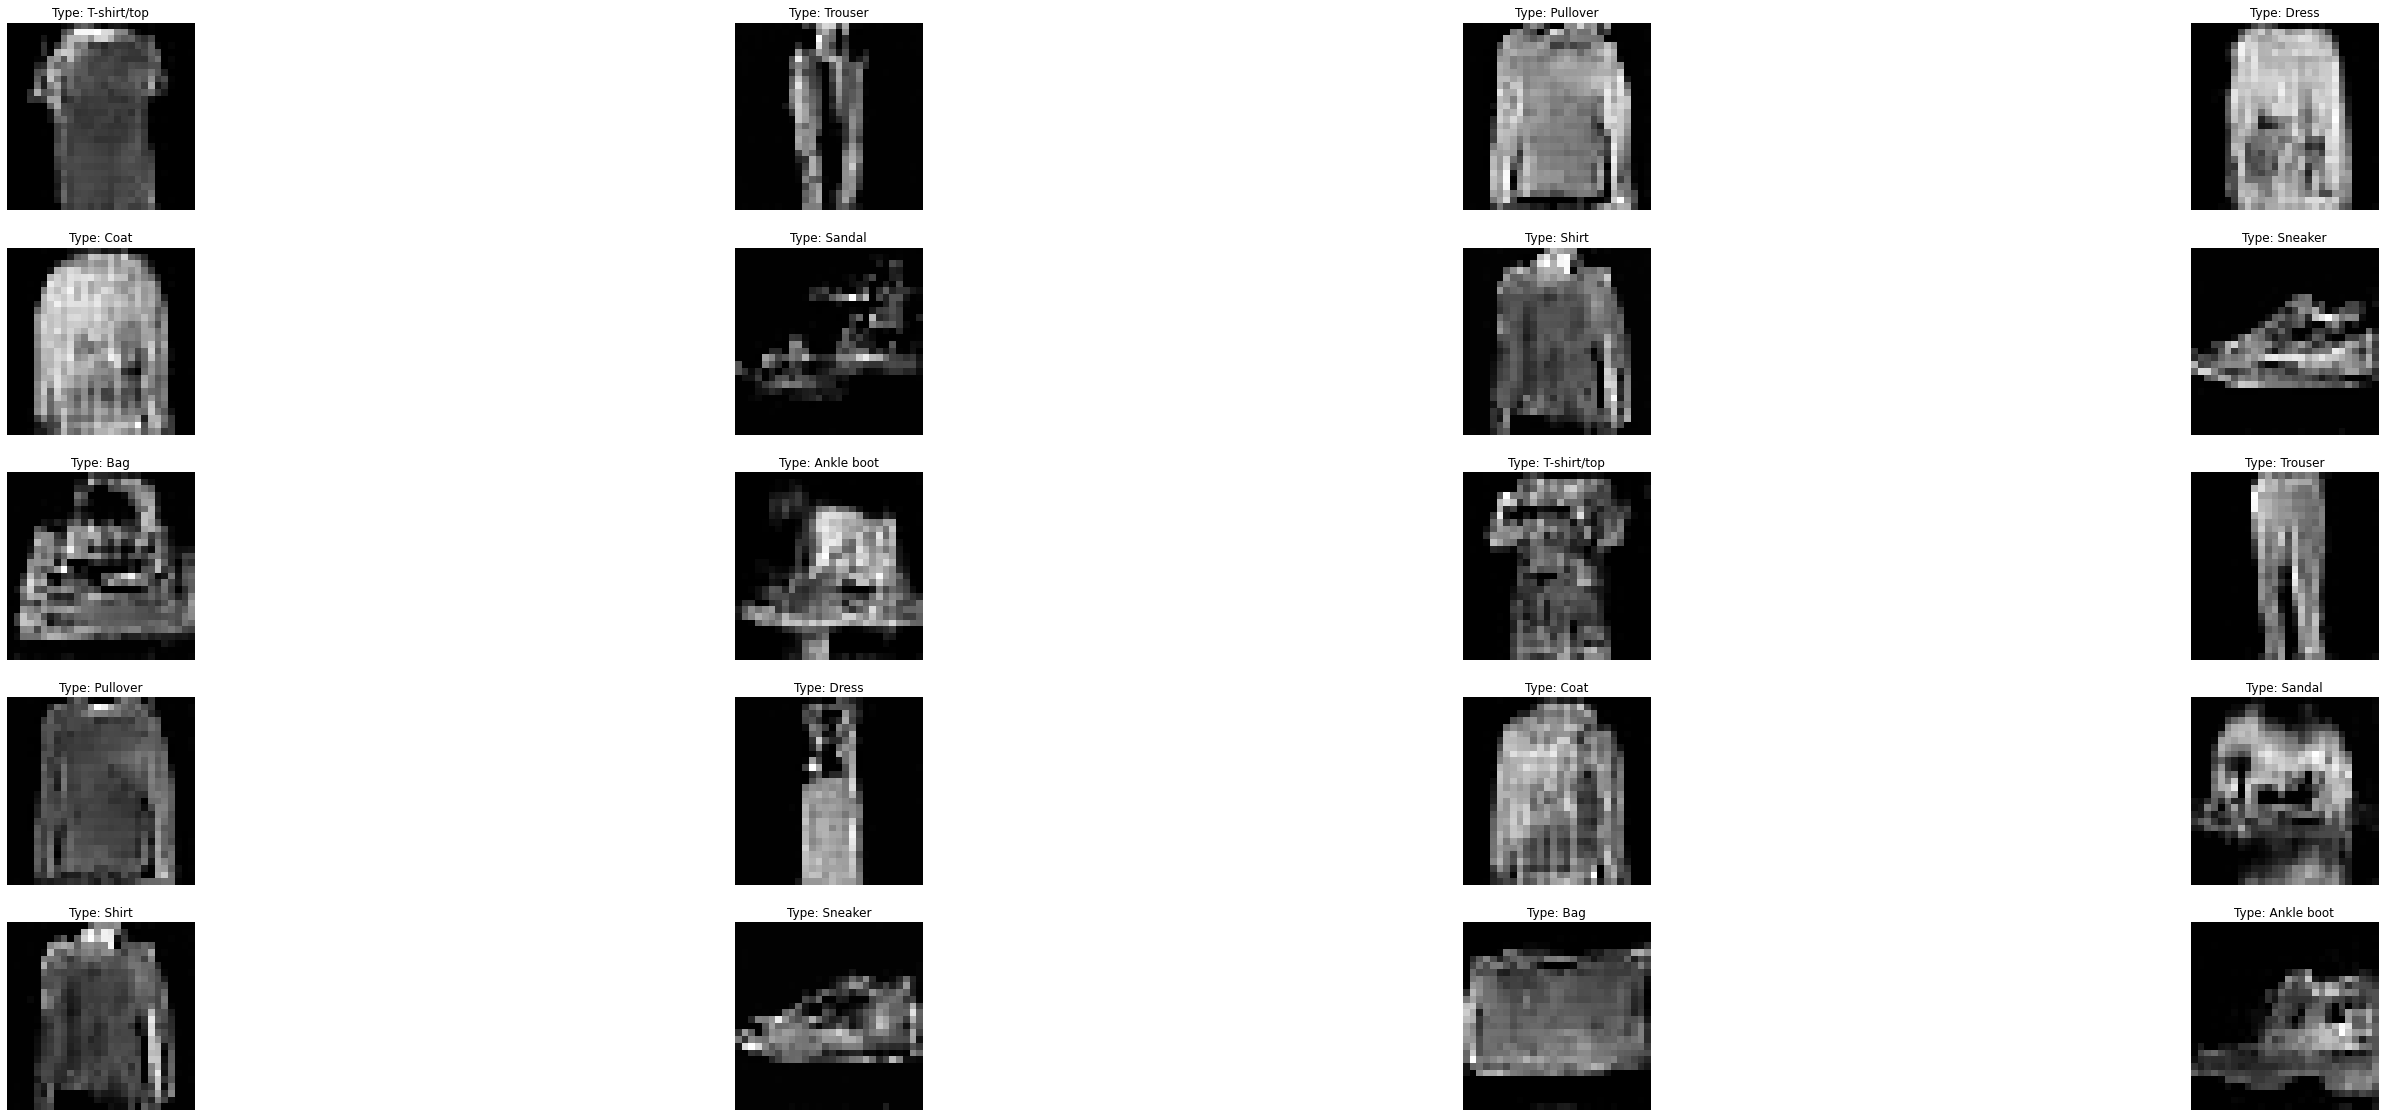

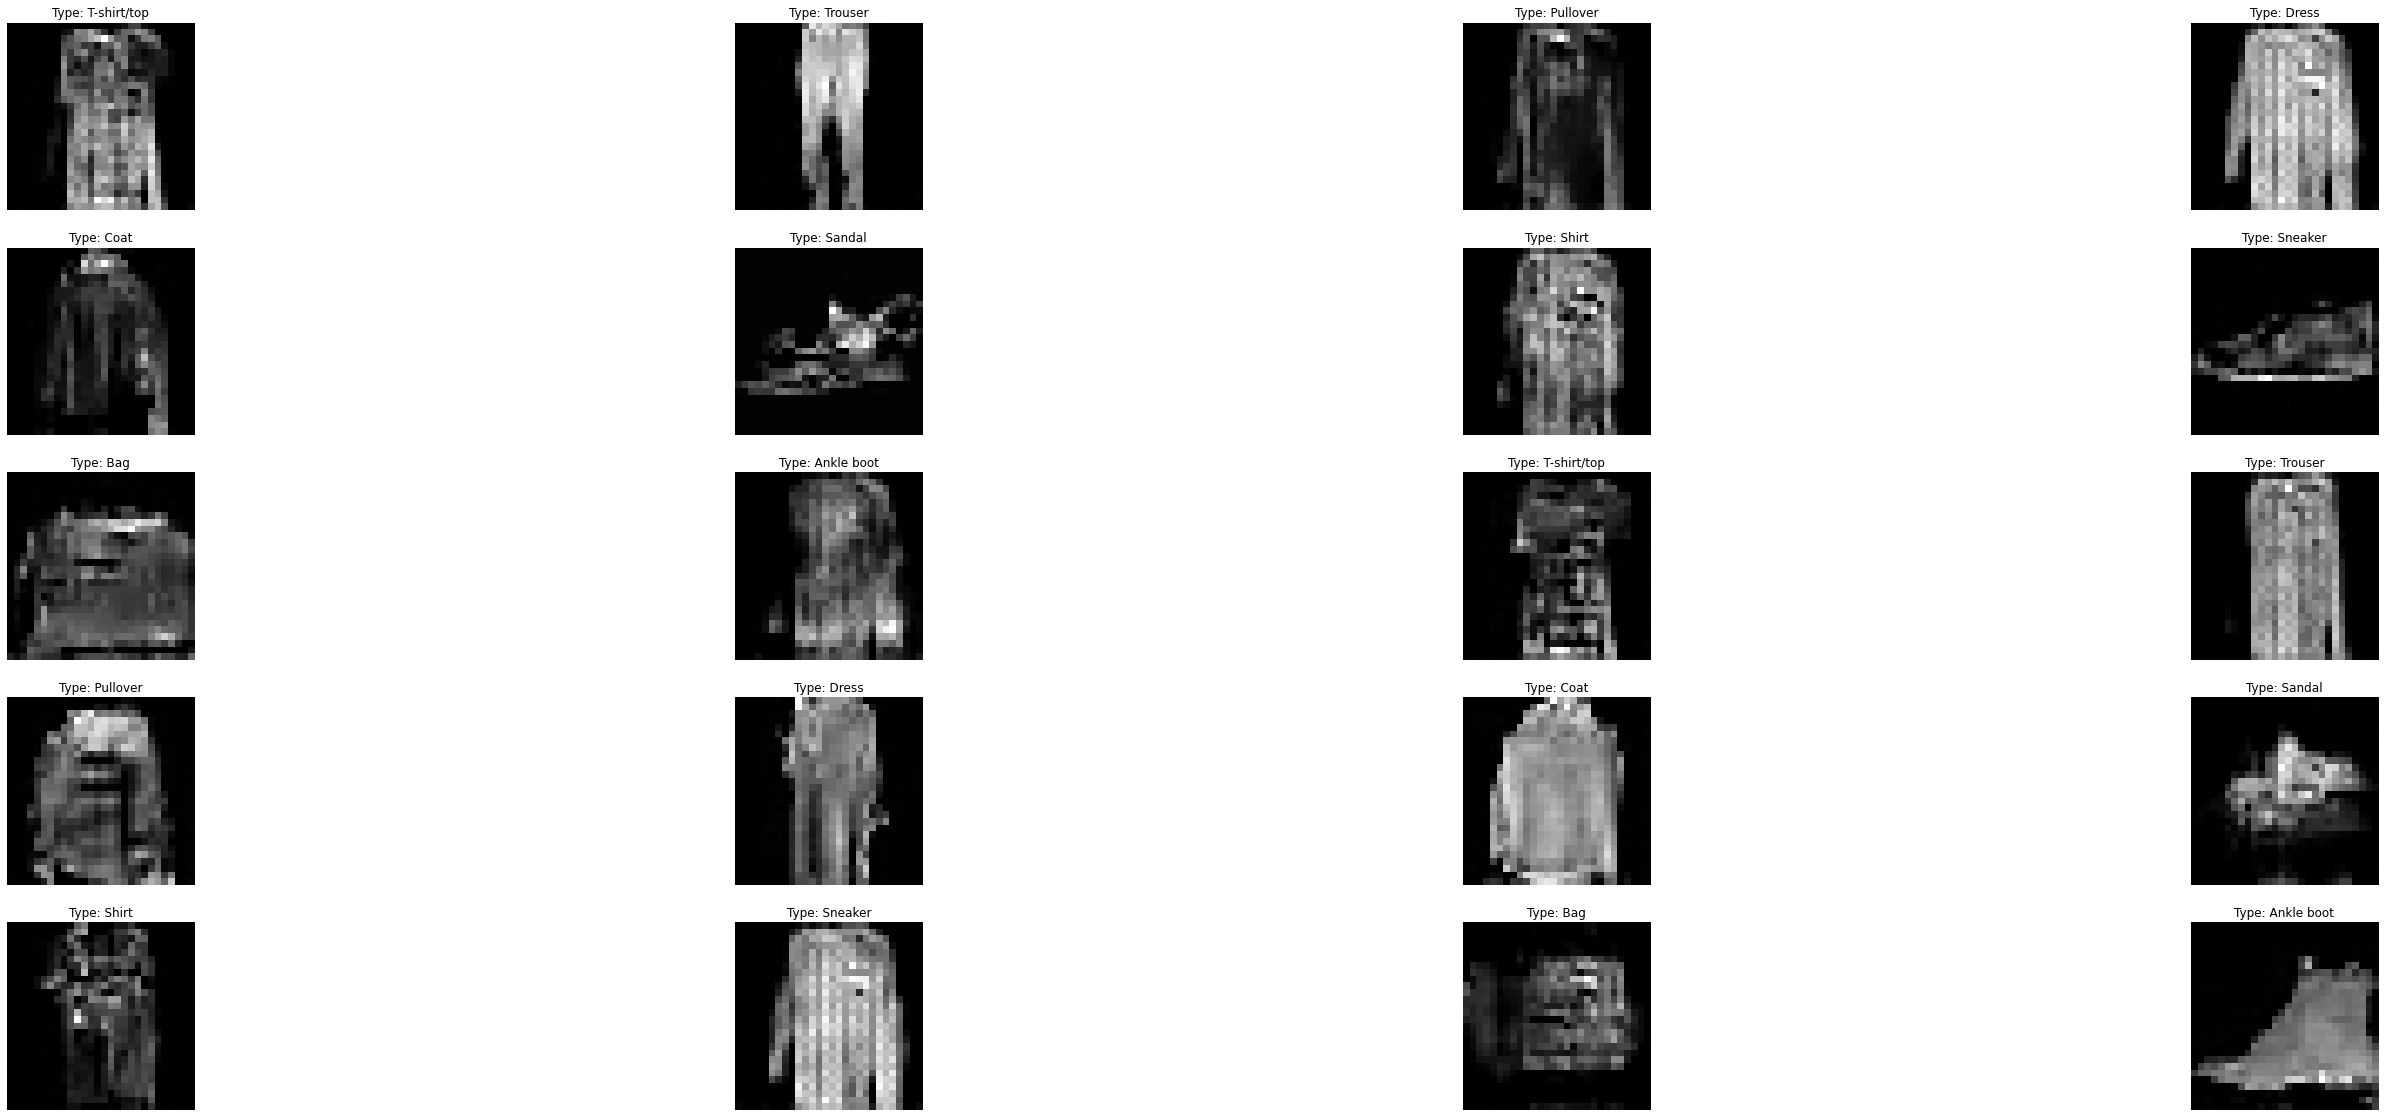

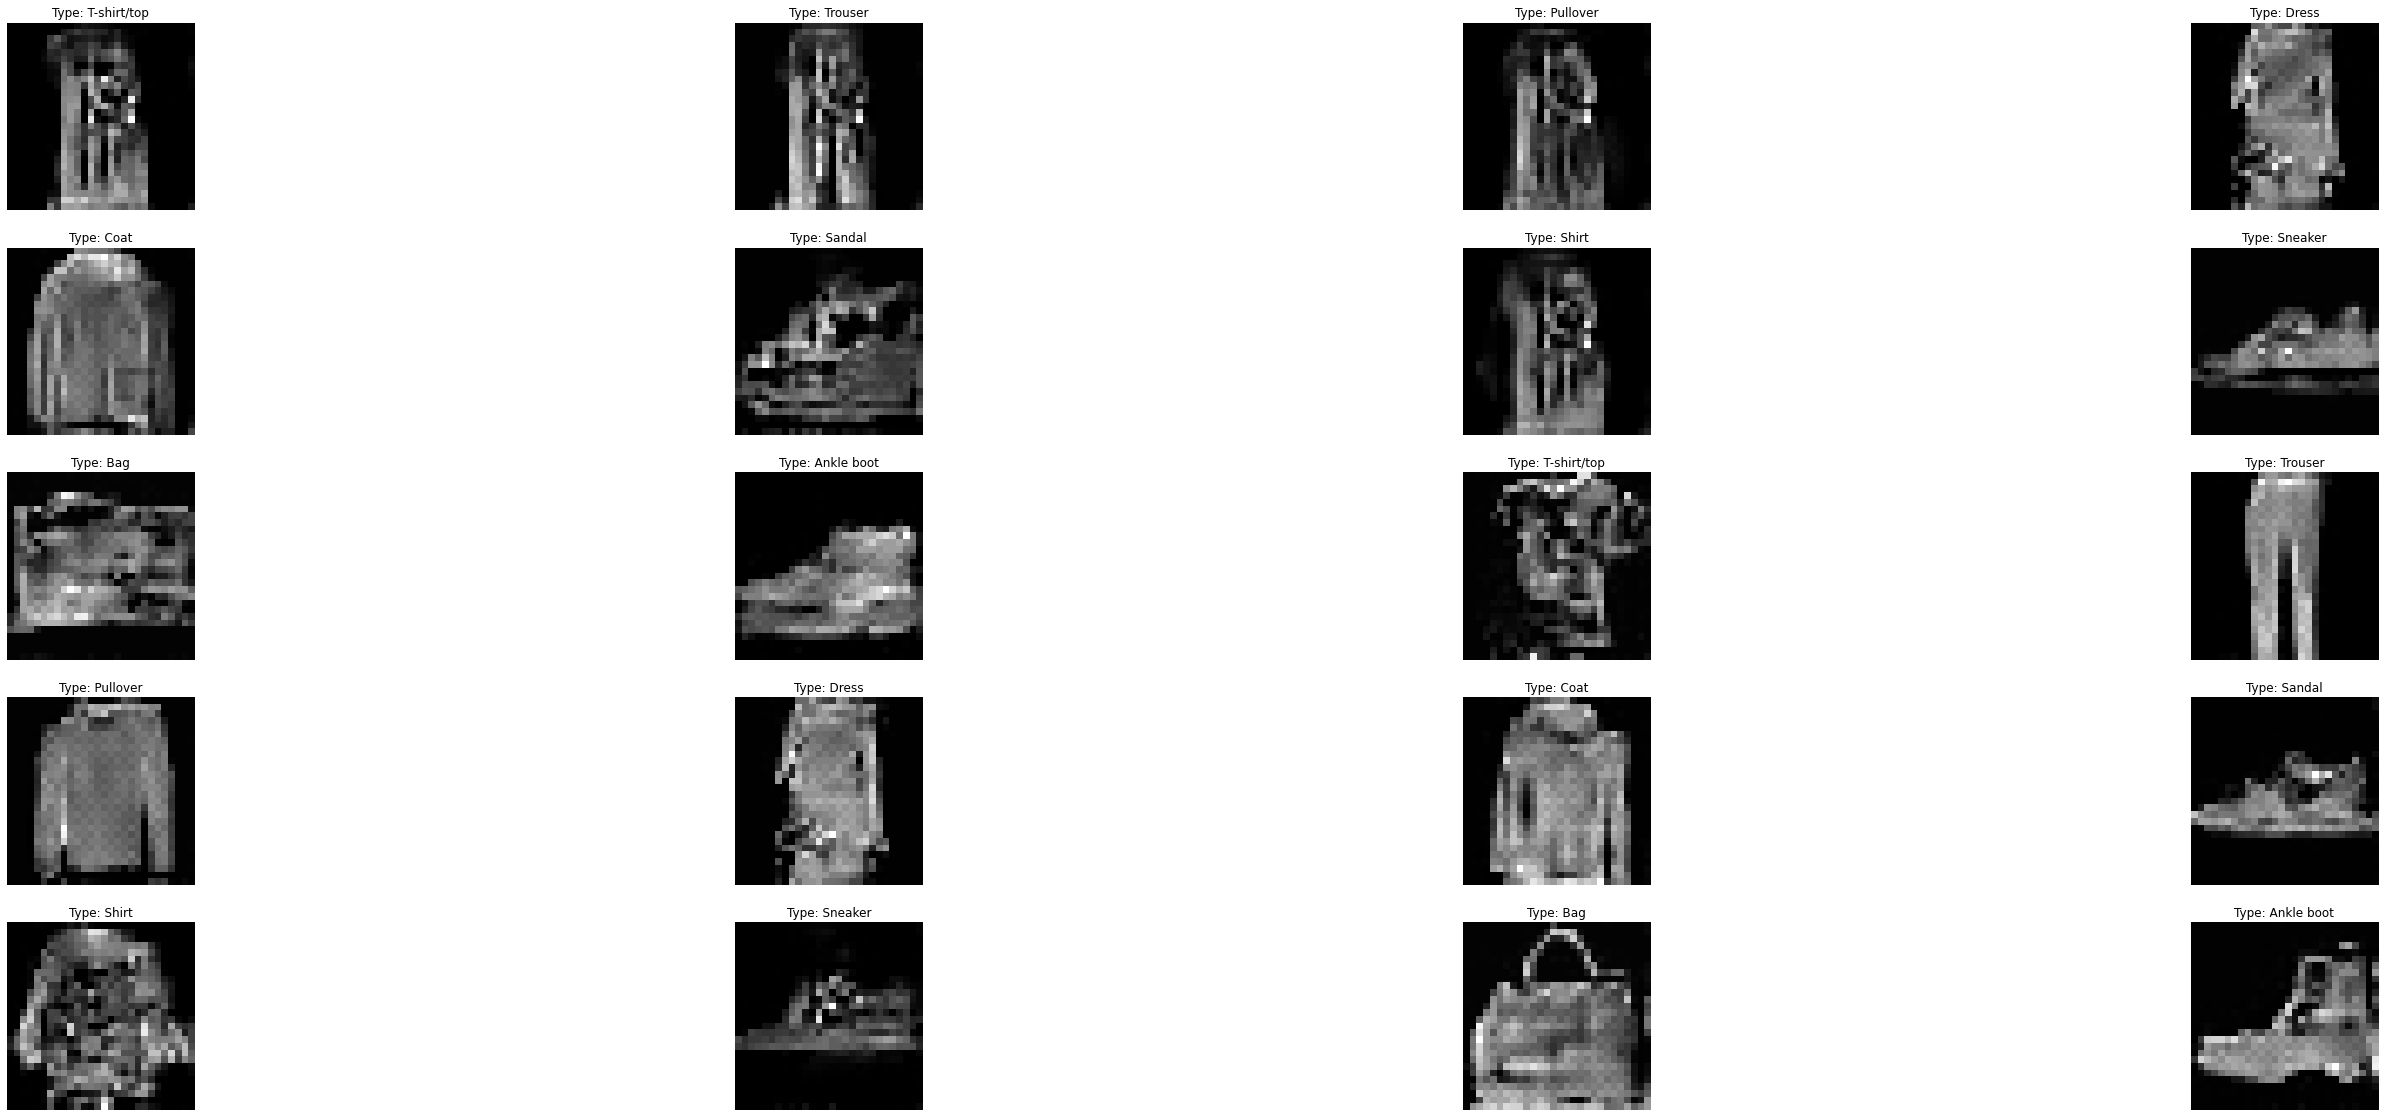

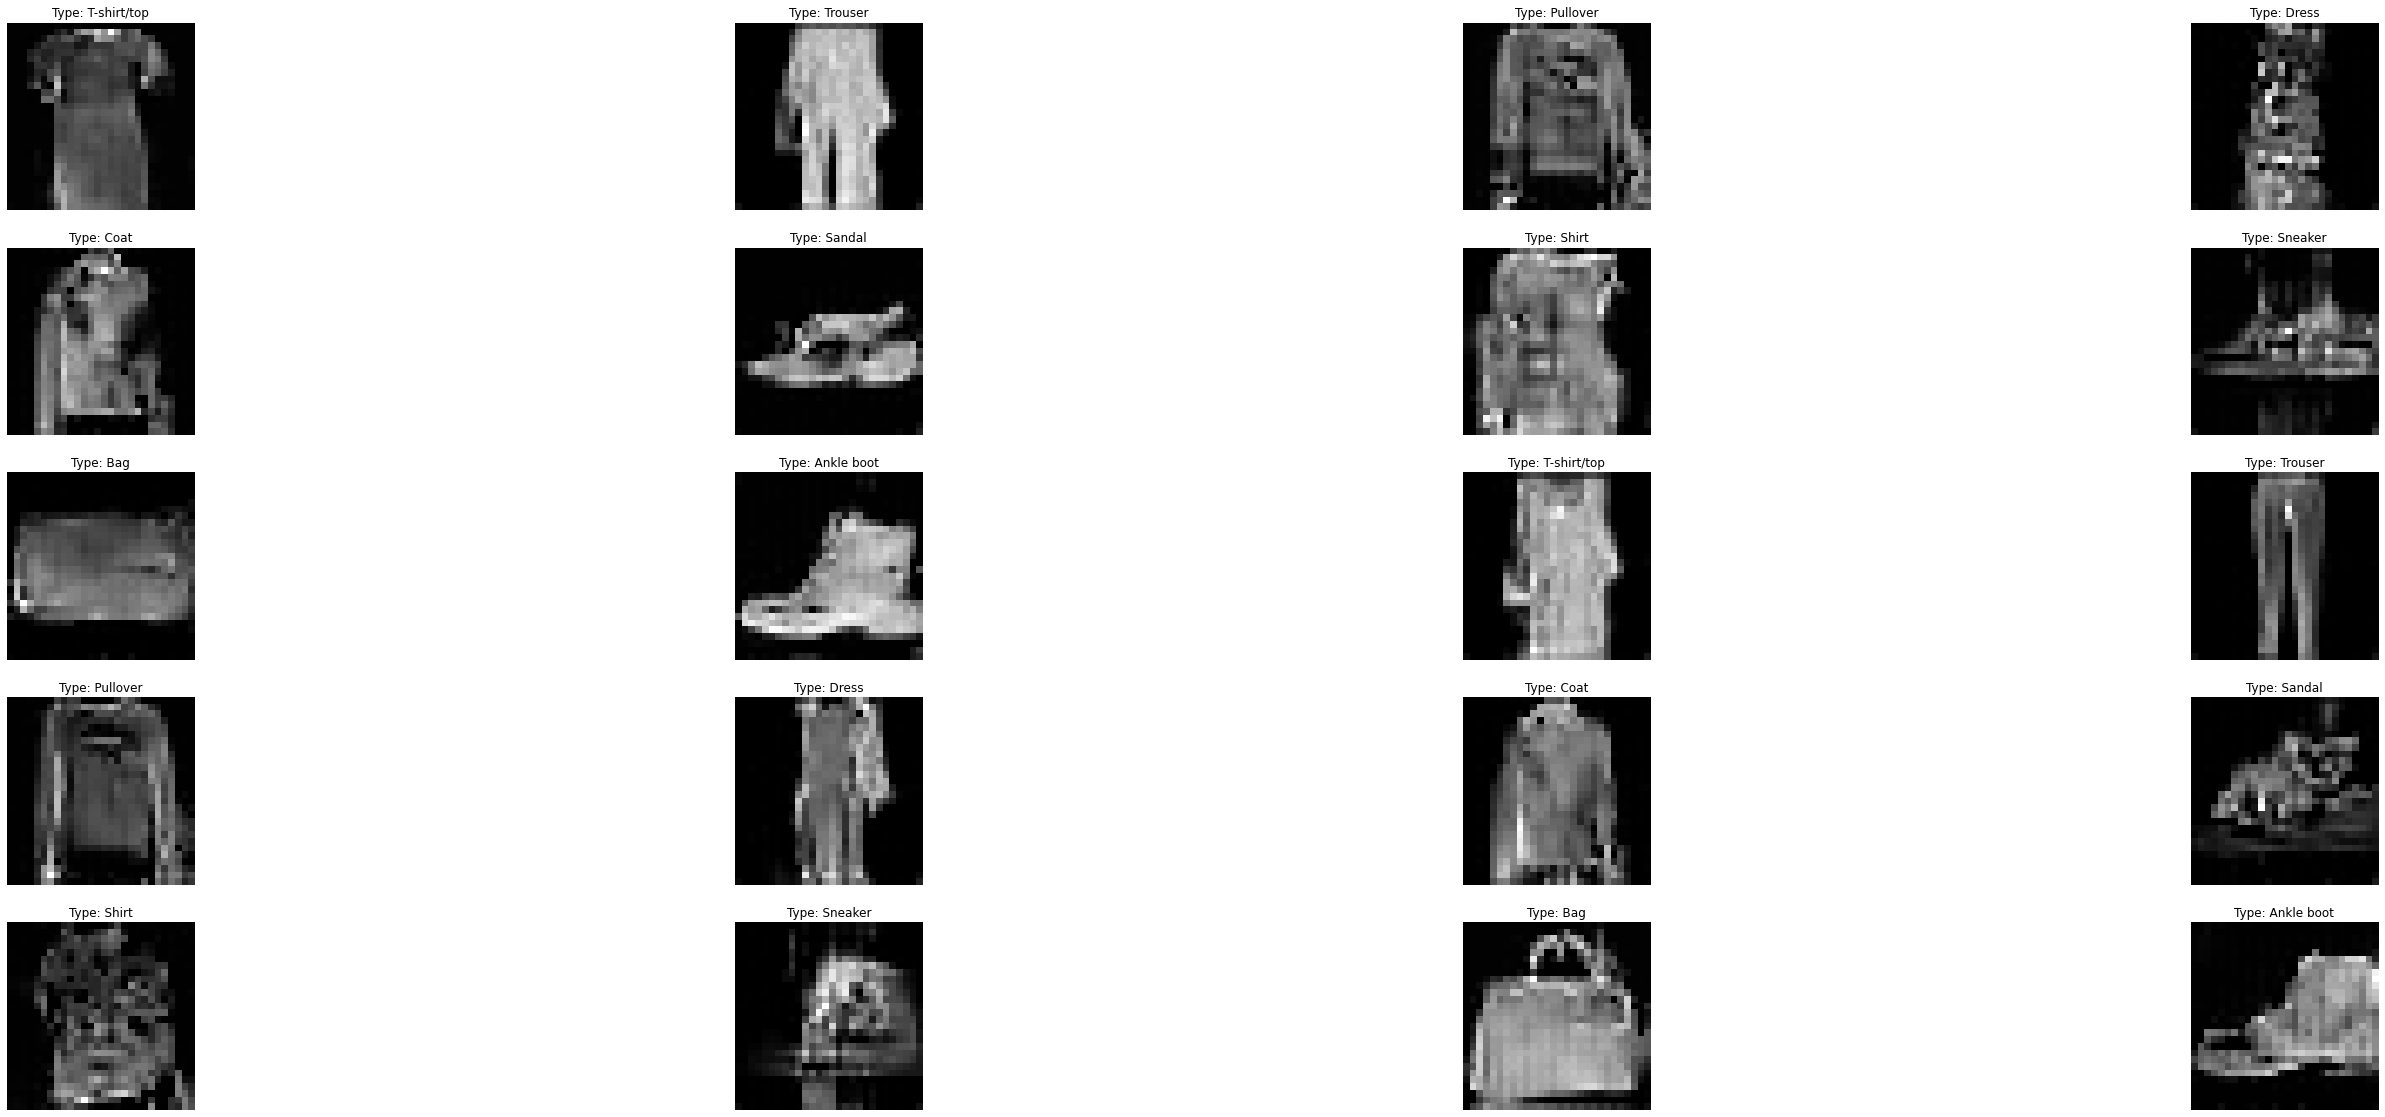

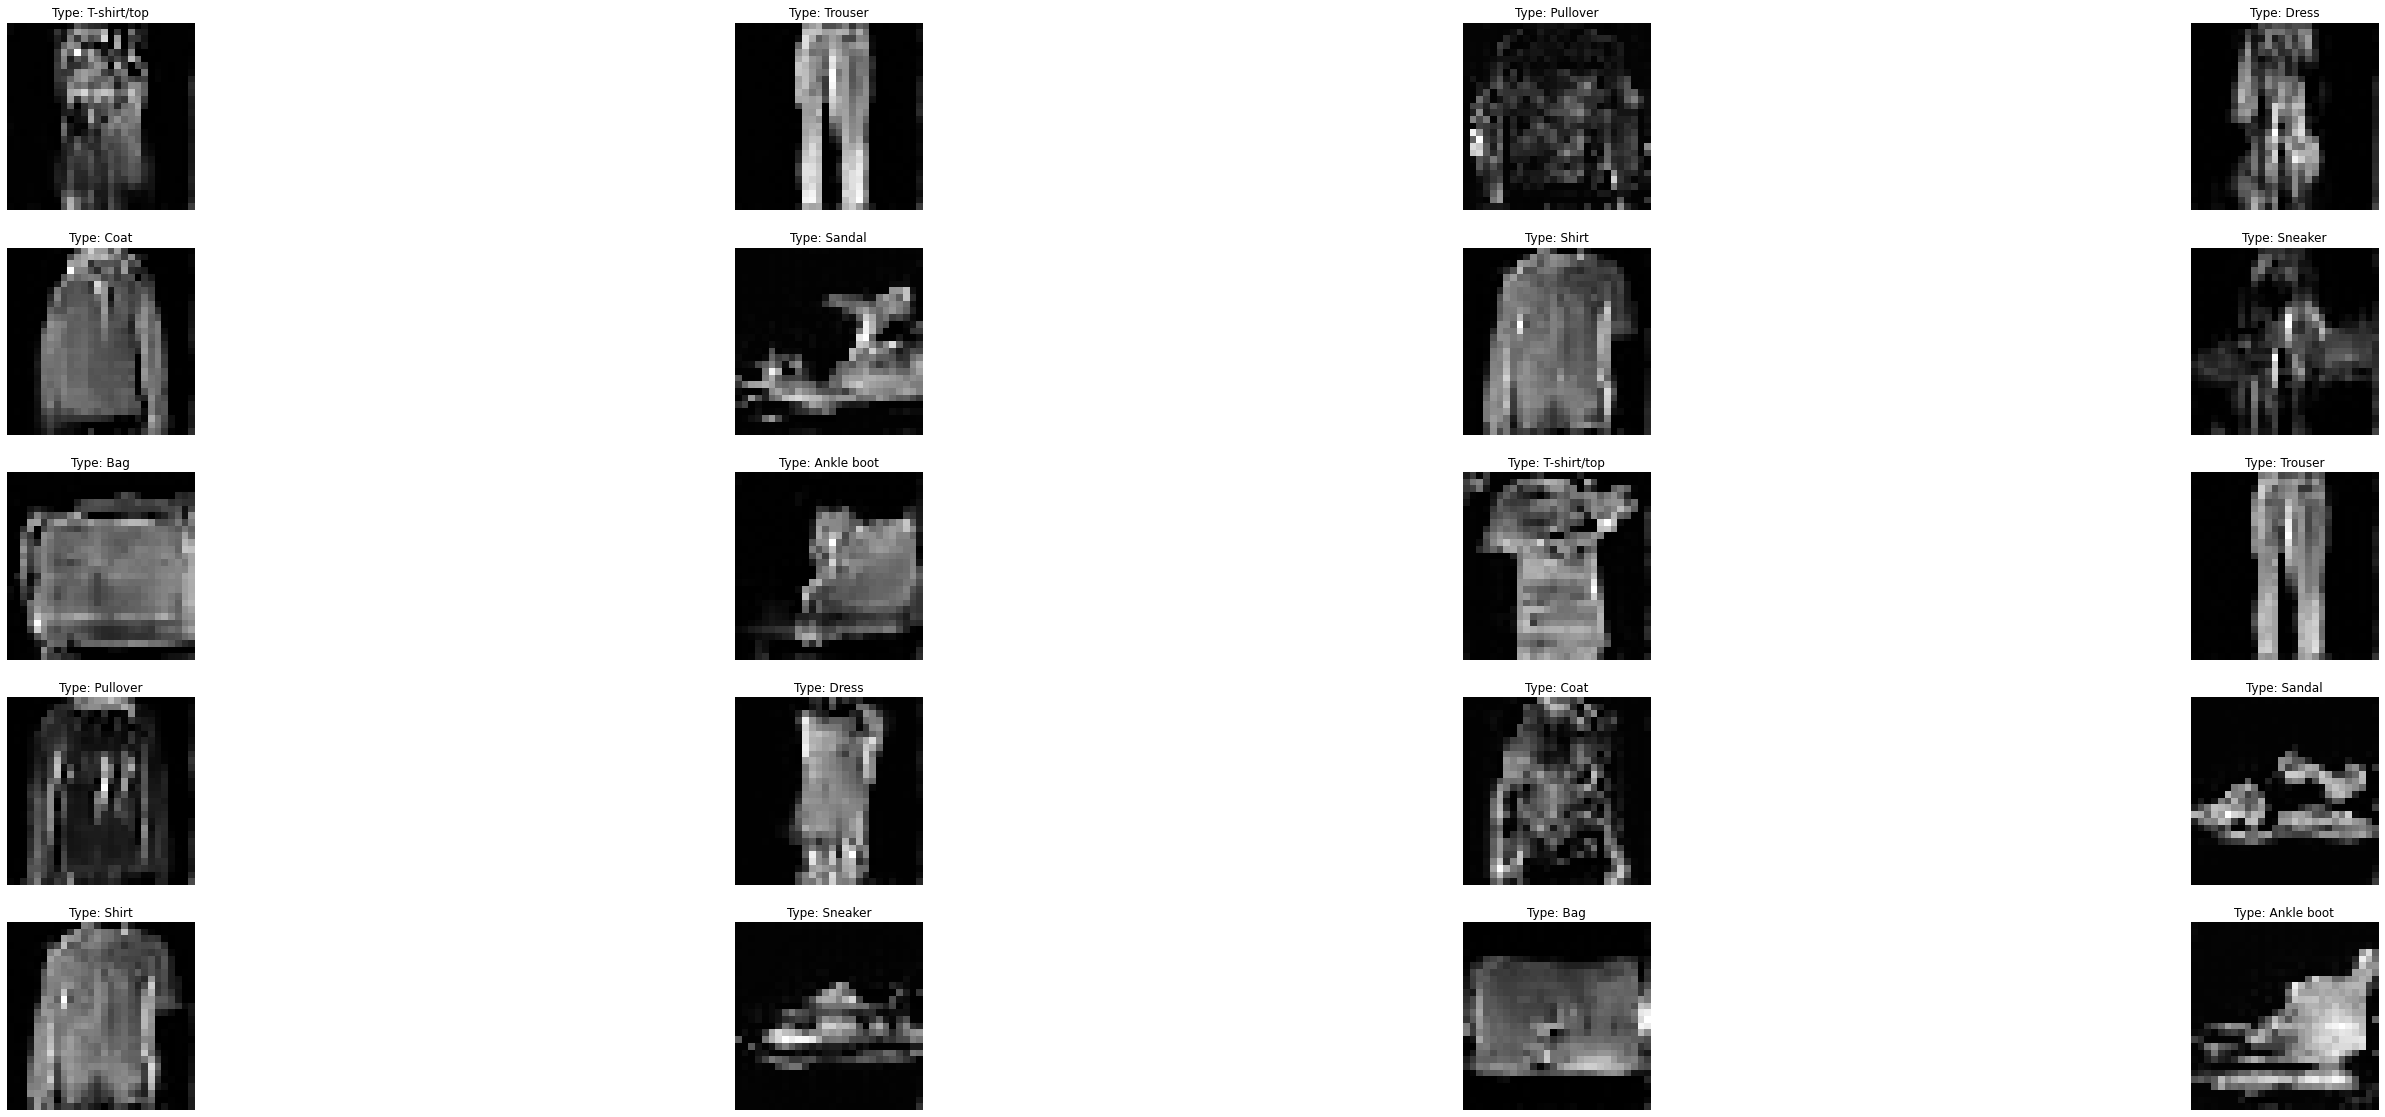

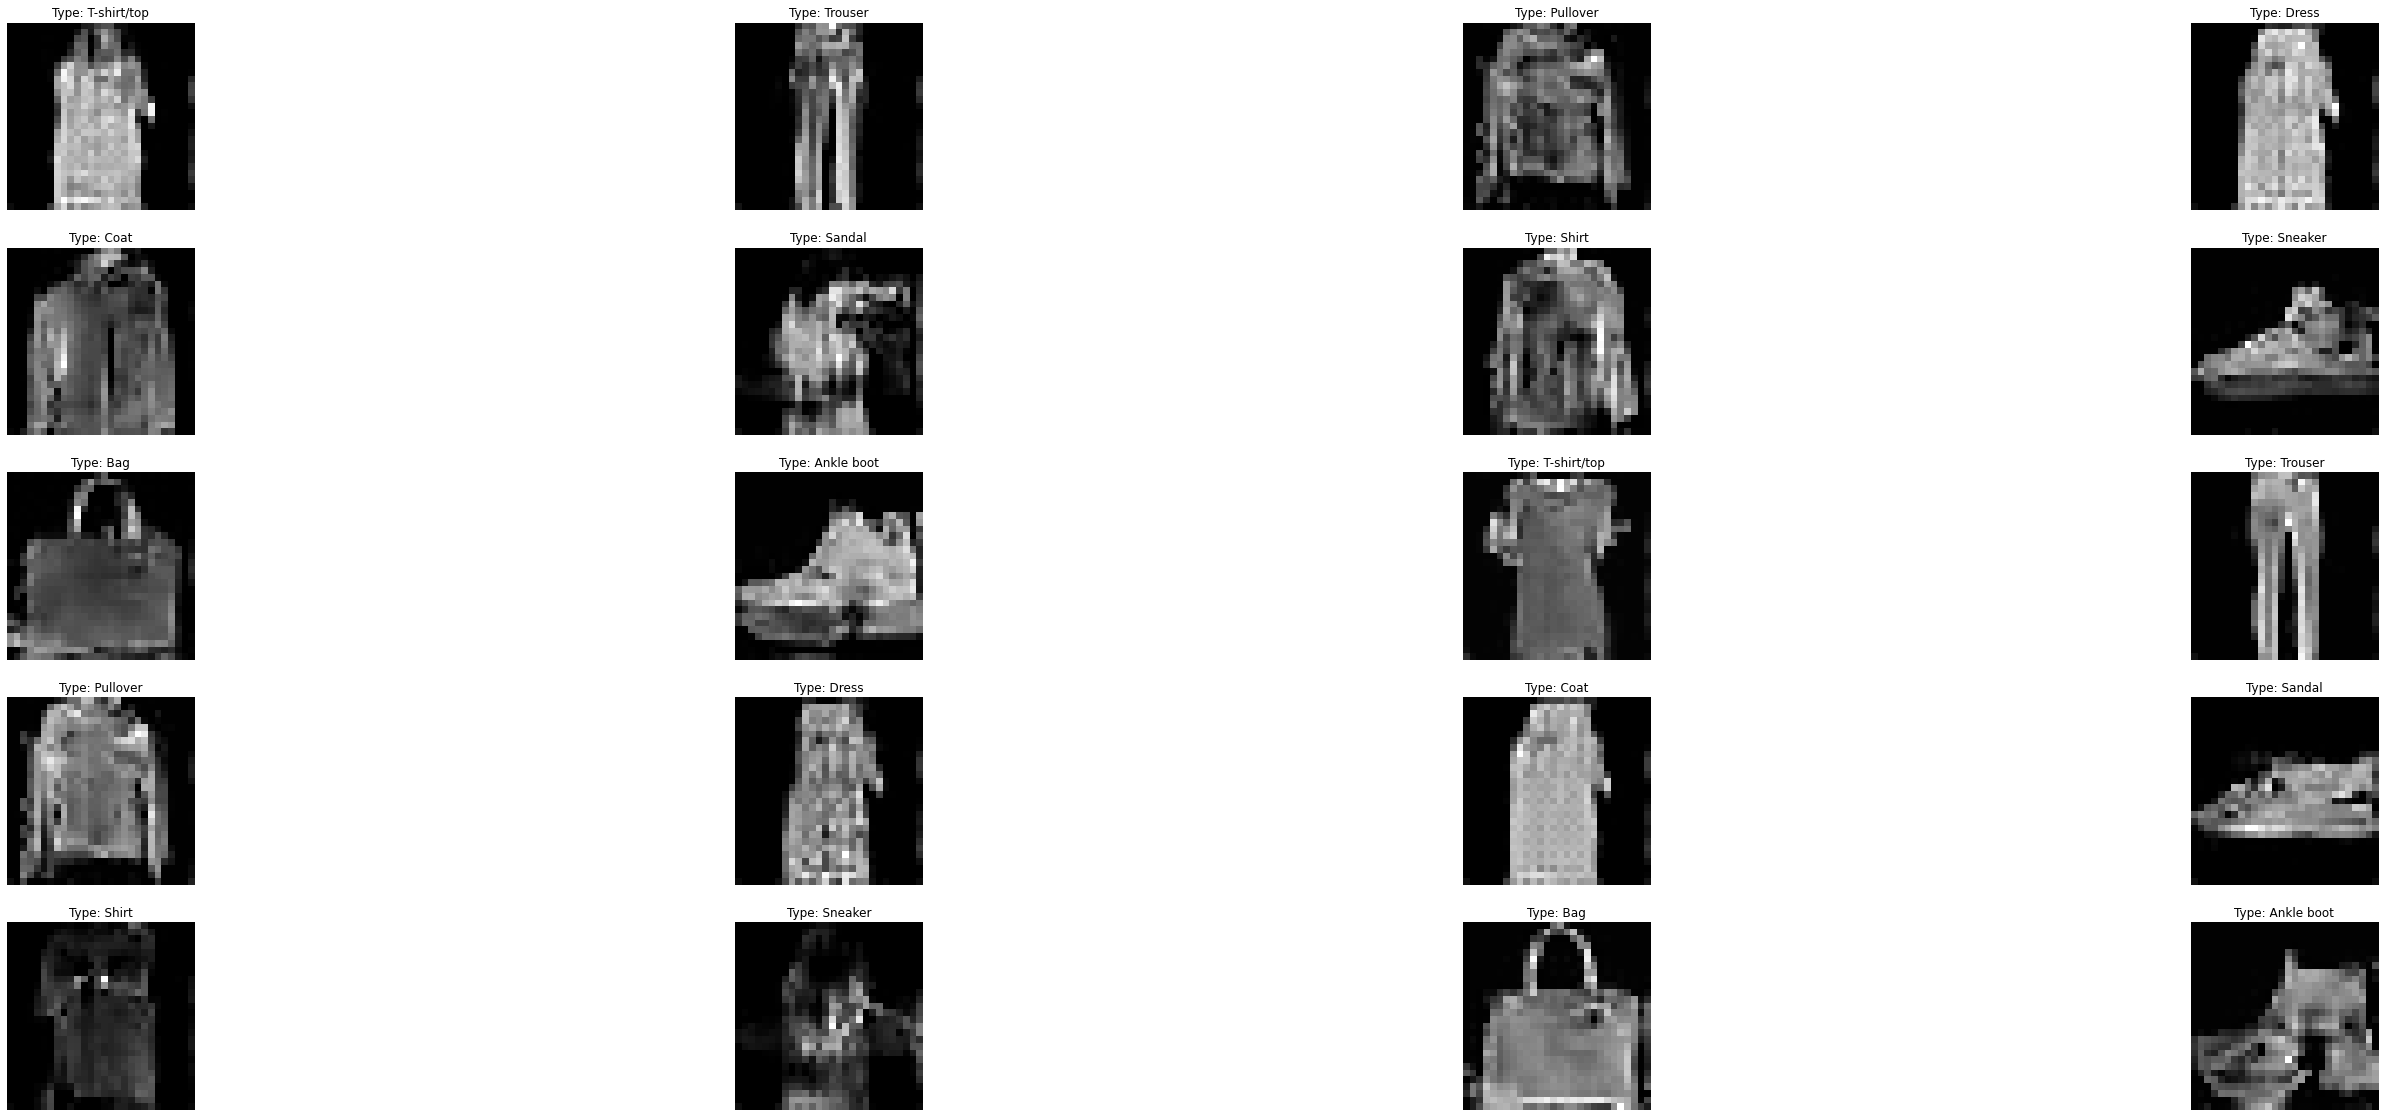

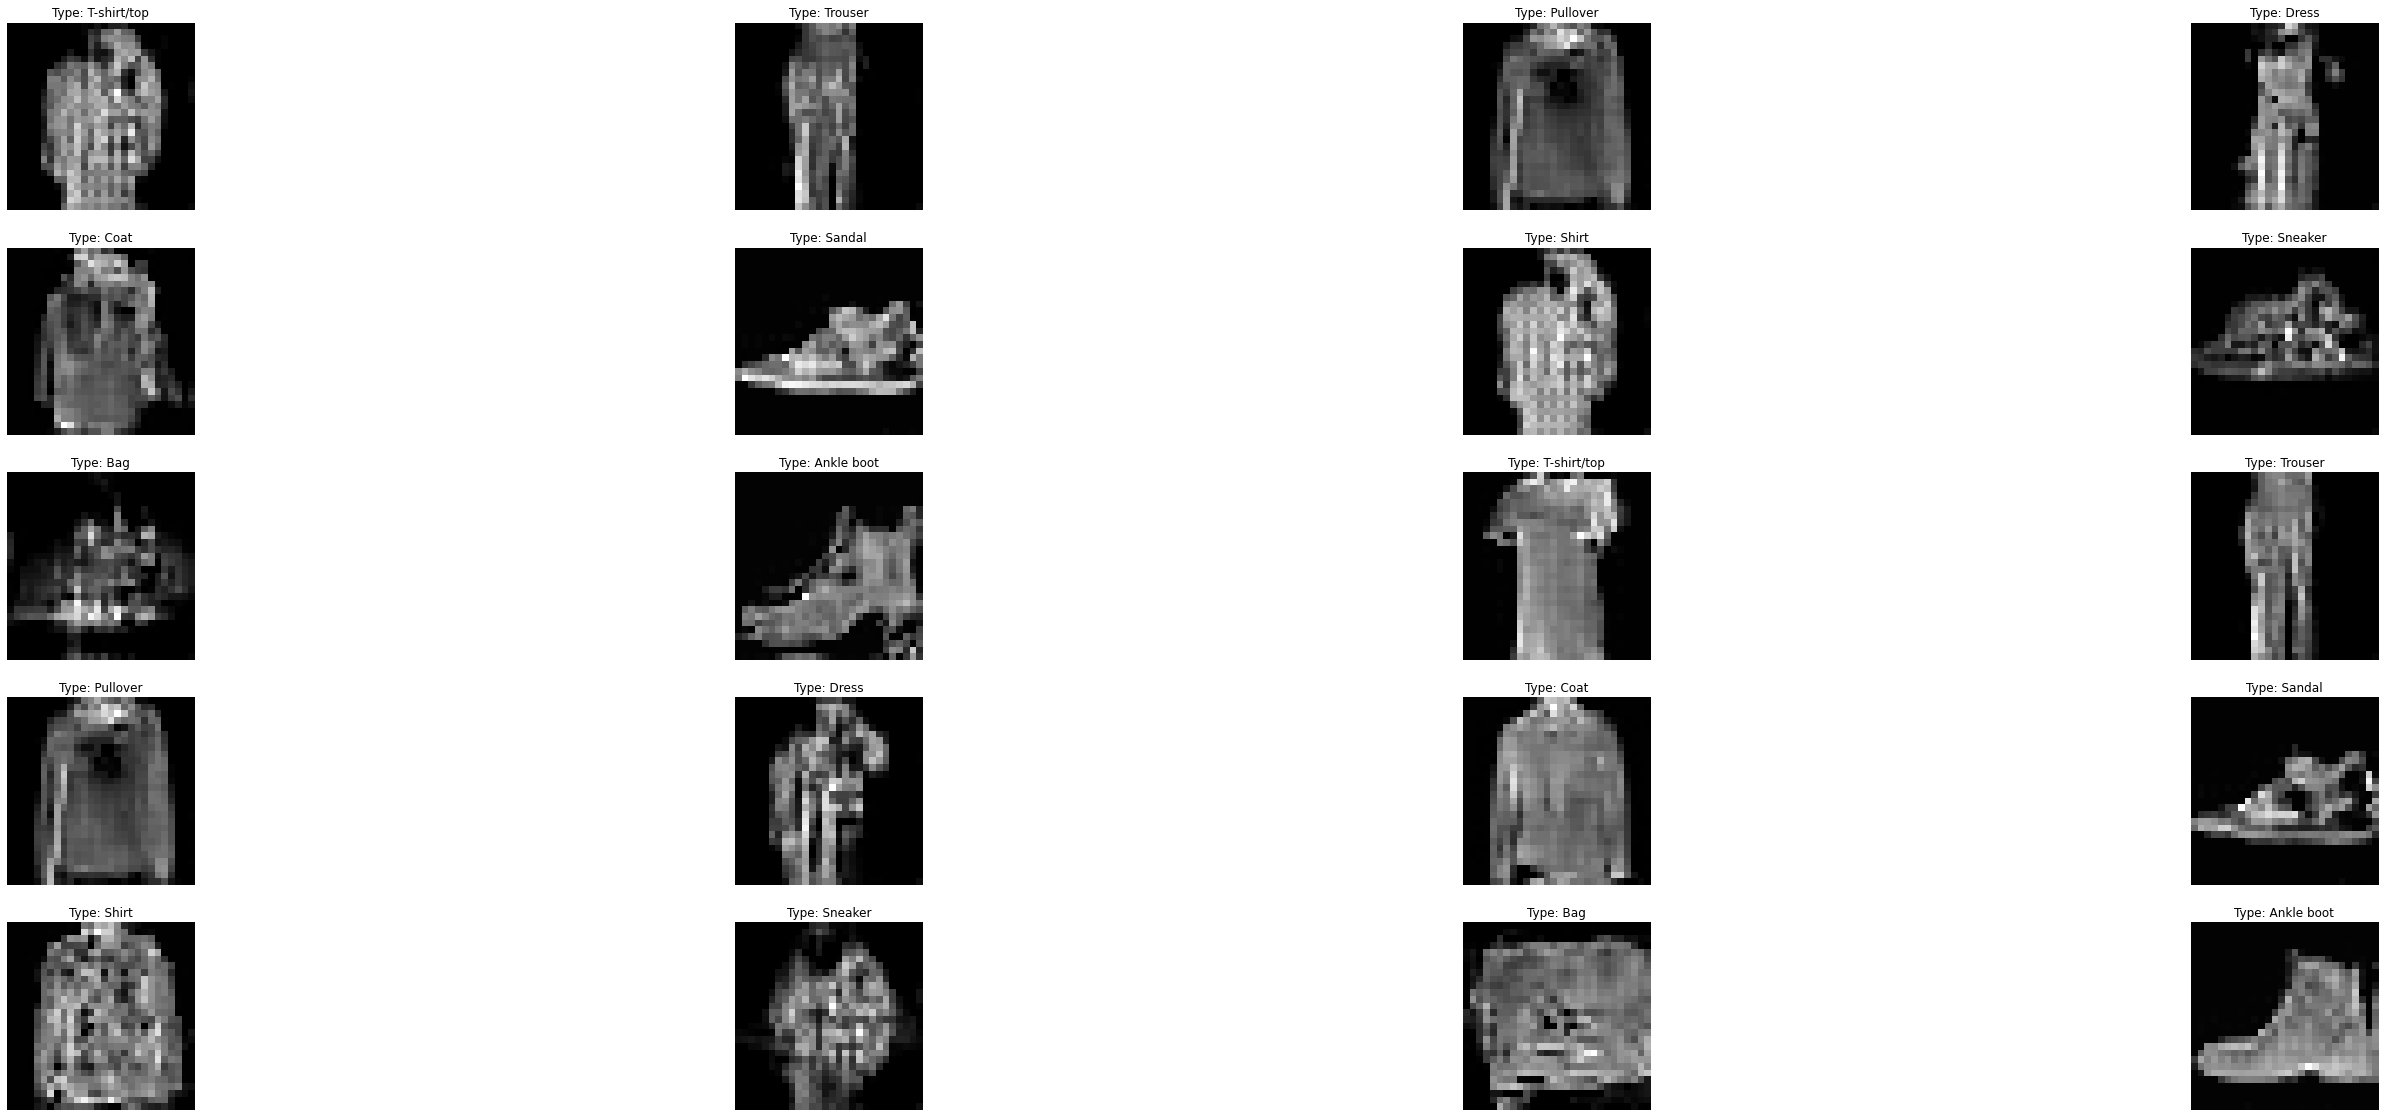

In [6]:
# label to category dictionary
dict_clothes ={0: "T-shirt/top",1: "Trouser",2: "Pullover",
               3: "Dress",4: "Coat",5: "Sandal",6: "Shirt",
               7: "Sneaker",8: "Bag",9: "Ankle boot"}

# function to plot and save sample images
def plot_sample_images(epoch ,rows=5,columns=4):

    z = np.random.normal(0, 1, (rows * columns, z_dim))
    a =np.arange(0,10)
    b =np.arange(0,10)

    labels = np.append(a,b).reshape(-1,1)
    
    gen_imgs = generator.predict([z, labels])

    gen_imgs = 0.5 * gen_imgs + 0.5
    print("Epoch : %d "%(epoch+1))
    fig, axs = plt.subplots(rows,
                            columns,
                            figsize =(50, 20),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(rows):
        for j in range(columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Type: %s" % dict_clothes.get(labels[cnt][0]))
            cnt += 1
    fig.savefig('image%d.jpg'%(epoch))

 
# define training step
def train(epochs, batch_size, sample_interval):
    #  import Fashion-MNIST dataset
    (x_train, y_train), (x_test, y_test)  = fashion_mnist.load_data()
    X_train = np.concatenate([x_train, x_test])
    Y_train = np.concatenate([y_train, y_test])

    X_train = X_train.astype("float32") / 255.0
    X_train = np.reshape(X_train, (-1, 28, 28, 1))


    real = np.ones((batch_size, 1))

    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs): 
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], Y_train[idx]

        z = np.random.normal(0, 1, (batch_size, z_dim))
        # generate images from generator
        gen_imgs = generator.predict([z, labels])
        # pass real an generated images to the discriminator and ctrain on them
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, z_dim))

        labels = np.random.randint(0, n_class, batch_size).reshape(-1, 1)
   
        g_loss = cgan.train_on_batch([z, labels], real)

        if (epoch + 1) % sample_interval == 0:

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(epoch + 1, d_loss[0], 100 * d_loss[1], g_loss))

            plot_sample_images(epoch+1)
iterations = 20000
batch_size = 128
sample_interval = 2000

train(iterations, batch_size, sample_interval)

In [7]:
anim_file = 'condition_gan.gif'
# for creating GIF
import imageio
import glob

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.jpg')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)